In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, MaxPooling2D, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
#Path1 = '/home/carnd/CarND-Behavioral-Cloning-P3/data/data/'
Path2 = '/home/carnd/CarND-Behavioral-Cloning-P3/my_data/' #Path to the csvFile
csvFile = Path2 + 'driving_log.csv'  #Path + csv file
imgPath = Path2 + 'IMG/' #Path to image folder

#The first row is the heading. So i am skipping it
Imgsamples = []
with open(csvFile) as file:
    reader = csv.reader(file)
    next(reader)  
    for line in reader:
        Imgsamples.append(line)

In [5]:
#Train and test images split 80:20
trainSamples, validationSamples = train_test_split(Imgsamples, test_size=0.2)

SteeringAngle : -0.01503759


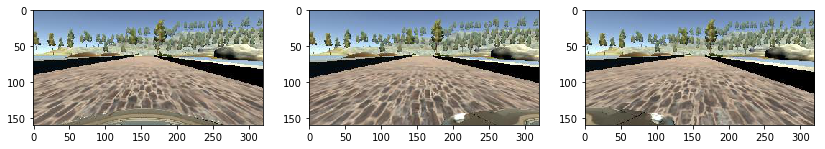

In [17]:
#Data visualization
%matplotlib inline

SampleImg = cv2.cvtColor(cv2.imread(imgPath+trainSamples[0][0].split('/')[-1]), cv2.COLOR_BGR2RGB)
leftImg  = cv2.cvtColor(cv2.imread(imgPath+trainSamples[0][1].split('/')[-1]), cv2.COLOR_BGR2RGB)
rightImg  = cv2.cvtColor(cv2.imread(imgPath+trainSamples[0][2].split('/')[-1]), cv2.COLOR_BGR2RGB)
print('SteeringAngle :', trainSamples[0][3] )

plt.figure(figsize=(14,12))
plt.subplot(1, 3, 1)
plt.imshow(SampleImg)

plt.subplot(1, 3, 2)
plt.imshow(leftImg)

plt.subplot(1, 3, 3)
plt.imshow(rightImg)




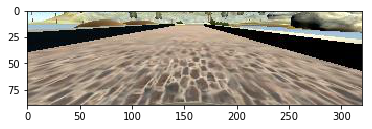

In [20]:
#Cropping images
plt.imshow(SampleImg[50:140,:,:])  #To remove sky and hood part

Flipped image


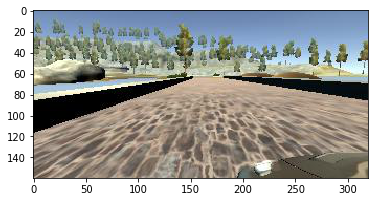

In [21]:
#Flipping images
print('Flipped image')
plt.imshow(np.fliplr(rightImg))

In [6]:
steerCorrection = 0.2 #Steering correction for right and left camera images
#Generator data 
colorSpace =  cv2.COLOR_BGR2RGB
def generator_data(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            Steerangles = []
            for batch_sample in batch_samples:

                # center camera images and steering angle
                name = imgPath+batch_sample[0].split('/')[-1]
                center_image = cv2.cvtColor(cv2.imread(name), colorSpace)
                center_angle = float(batch_sample[3])

                # left camera images and steering angle
                name = imgPath+batch_sample[1].split('/')[-1]
                left_image = cv2.cvtColor(cv2.imread(name), colorSpace)
                left_angle = center_angle + steerCorrection
                left_angle = min(max(left_angle, -1.0), 1.0)

                # right camera images and steering angle
                name = imgPath+batch_sample[2].split('/')[-1]
                right_image = cv2.cvtColor(cv2.imread(name), colorSpace)
                right_angle = center_angle - steerCorrection
                right_angle = min(max(right_angle, -1.0), 1.0)

                
                images.append(center_image)
                Steerangles.append(center_angle)
                images.append(left_image)
                Steerangles.append(left_angle)
                images.append(right_image)
                Steerangles.append(right_angle)
            #Collect all the camera images    
            X_train_orig = np.array(images)
            y_train_orig = np.array(Steerangles)
            
            # Flip the images
            X_train_flip = np.array(np.fliplr(images))
            y_train_flip =-np.array(Steerangles)
            
            #Concatenate all the images
            X_train = np.concatenate((X_train_orig, X_train_flip), axis=0)
            y_train = np.concatenate((y_train_orig, y_train_flip), axis=0)
            #Shuffle
            yield sklearn.utils.shuffle(X_train, y_train)

In [7]:
train_generator = generator_data(trainSamples, batch_size=32)
validation_generator = generator_data(validationSamples, batch_size=32)

In [8]:
IMG1 = cv2.cvtColor(cv2.imread(imgPath+trainSamples[0][0].split('/')[-1]), colorSpace)
print(IMG1.shape)
shape = IMG1.shape

(160, 320, 3)


In [9]:
'''
model = Sequential()
model.add(Lambda(lambda x: ((x/127.0)-0.5),input_shape=shape,name='lambda'))
model.add(Cropping2D(cropping=((60,30),(0,0)),name='crop'))
model.add(Conv2D(nb_filter=24,nb_row=5,nb_col=5,subsample=(1,2),border_mode='valid',activation='elu',name='conv1'))
model.add(Conv2D(nb_filter=36,nb_row=5,nb_col=5,subsample=(2,2),border_mode='valid',activation='elu',name='conv2'))
model.add(Conv2D(nb_filter=48,nb_row=5,nb_col=5,subsample=(2,2),border_mode='valid',activation='elu',name='conv3'))
model.add(Conv2D(nb_filter=64,nb_row=3,nb_col=3,subsample=(2,2),border_mode='valid',activation='elu',name='conv4'))
model.add(Conv2D(nb_filter=64,nb_row=3,nb_col=3,subsample=(2,2),border_mode='valid',activation='elu',name='conv5'))
model.add(Flatten(name='flat'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(1164, activation='elu', name='dense1'))
model.add(Dense(100, activation='elu', name='dense2'))
model.add(Dense(50, activation='elu', name='dense3'))
model.add(Dense(10, activation='elu', name='dense4'))
model.add(Dense(1, name='output'))
model.compile(loss='mse',optimizer='adam')

"\nmodel = Sequential()\nmodel.add(Lambda(lambda x: ((x/127.0)-0.5),\n                 input_shape=shape,\n                 name='lambda'))\nmodel.add(Cropping2D(cropping=((60,30),(0,0)),\n                     name='crop'))\nmodel.add(Conv2D(nb_filter=24,\n                 nb_row=5,\n                 nb_col=5,\n                 subsample=(1,2),\n                 border_mode='valid',\n                 activation='elu',\n                 name='conv1'))\nmodel.add(Conv2D(nb_filter=36,\n                 nb_row=5,\n                 nb_col=5,\n                 subsample=(2,2),\n                 border_mode='valid',\n                 activation='elu',\n                 name='conv2'))\nmodel.add(Conv2D(nb_filter=48,\n                 nb_row=5,\n                 nb_col=5,\n                 subsample=(2,2),\n                 border_mode='valid',\n                 activation='elu',\n                 name='conv3'))\nmodel.add(Conv2D(nb_filter=64,\n                 nb_row=3,\n                 nb_co

In [10]:

model = Sequential()
model.add(Lambda(lambda x: ((x/255.0)-0.5),input_shape=shape,name='lambda'))
model.add(Cropping2D(cropping=((50,20),(0,0)),name='crop'))
model.add(Conv2D(nb_filter=24,nb_row=5,nb_col=5,subsample=(2,2),border_mode='valid',activation='elu',name='conv1'))
model.add(Conv2D(nb_filter=36,nb_row=5,nb_col=5,subsample=(2,2),border_mode='valid',activation='elu',name='conv2'))
model.add(Conv2D(nb_filter=48,nb_row=5,nb_col=5,subsample=(2,2),border_mode='valid',activation='elu',name='conv3'))
model.add(Conv2D(nb_filter=64,nb_row=3,nb_col=3,subsample=(2,2),border_mode='valid',activation='elu',name='conv4'))
model.add(Conv2D(nb_filter=64,nb_row=3,nb_col=3,subsample=(2,2),border_mode='valid',activation='elu',name='conv5'))
model.add(Flatten(name='flat'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(100, activation='elu', name='dense1'))
model.add(Dense(50, activation='elu', name='dense2'))
model.add(Dense(10, activation='elu', name='dense3'))
model.add(Dense(1, name='output'))
model.compile(loss='mse',optimizer='adam')


In [11]:
save_filename = 'model.h5'
'''checkpoint = ModelCheckpoint(save_filename,monitor='val_loss',save_best_only=True,save_weights_only=False)
callbacks_list = [checkpoint]'''


"checkpoint = ModelCheckpoint(save_filename,\n                             monitor='val_loss',\n                             save_best_only=True,\n                             save_weights_only=False)\ncallbacks_list = [checkpoint]"

In [12]:
history_obj =  model.fit_generator(train_generator,
                                   samples_per_epoch=len(trainSamples)*6,
                                   validation_data=validation_generator,
                                   nb_val_samples=len(validationSamples)*6,
                                   nb_epoch=2)
model.save(save_filename)

Epoch 1/2
358602/358602 [==============================] - 812s - loss: 0.0181 - val_loss: 0.0151
Epoch 2/2
358602/358602 [==============================] - 782s - loss: 0.0153 - val_loss: 0.0137
